# Periodogram Search for GRB 230307A INTEGRAL Data

First, let's use periodograms to explore the signal:

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

import numpy as np
import scipy
import pickle

import jax
# Important to enable 64-bit precision
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import random
import tensorflow_probability.substrates.jax as tfp

from tinygp import GaussianProcess, kernels
from jaxns.utils import resample

import stingray
from stingray import Lightcurve, Powerspectrum
from stingray.modeling.gpmodeling import get_kernel, get_mean
from stingray.modeling.gpmodeling import get_prior, get_log_likelihood, get_gp_params

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

# abbreviations for tensorflow distributions + bijectors
tfpd = tfp.distributions
tfpb = tfp.bijectors


INFO[2024-06-04 08:02:47,392]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
I0000 00:00:1717480967.391935       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
INFO[2024-06-04 08:02:47,393]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2024-06-04 08:02:47,406]: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/grbsearch/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)
/Users/daniela/work/repositories/stingraysoftware/stingray/stingray/utils.py:35: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn(

In [1]:
!pwd

/Users/daniela/work/repositories/GRB230307A_QPOSearch/notebooks


INFO[2024-06-04 08:02:52,802]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2024-06-04 08:02:52,906]: Checking if light curve is sorted.
INFO[2024-06-04 08:02:53,011]: Computing the bin time ``dt``. This can take time. If you know the bin time, please specify it at light curve creation


Text(0, 0.5, 'Leahy-normalized Power')

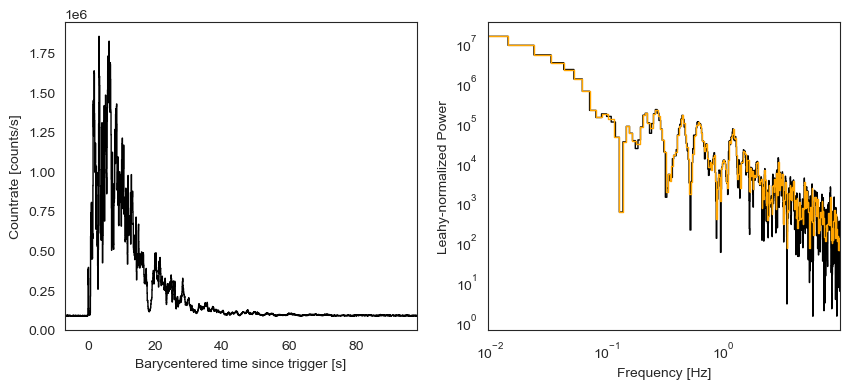

In [2]:
datadir = "../data/"
figdir = "../figures/"

data = scipy.io.readsav(datadir+"acs_lc_bary.sav")

barytime = np.array(data["barytime"], dtype=float)
#minind = barytime.searchsorted(0.0)
#maxind = barytime.searchsorted(60.0)

counts = np.array(data["counts"], dtype=float)

barytime = barytime#[minind:maxind]
counts = counts#[minind:maxind]

#mean_bkg = np.mean(counts[-100:])
mean_bkg = 0.0

lc = Lightcurve(barytime, counts)
#minind = lc.time.searchsorted(0.0)
#maxind = lc.time.searchsorted(60.0)
#lc = lc.truncate(start=minind, stop=maxind, method="index")
ps = Powerspectrum(lc, norm="leahy")
ps_log = ps.rebin_log()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.plot(lc.time, lc.countrate, lw=1, color="black", ds="steps-mid")
ax1.set_xlim(lc.time[0], lc.time[-1])
ax1.set_xlabel("Barycentered time since trigger [s]")
ax1.set_ylabel("Countrate [counts/s]")

ax2.loglog(ps.freq, ps.power, ds="steps-mid", lw=1, color="black")
ax2.loglog(ps_log.freq, ps_log.power, ds="steps-mid", lw=1, color="orange")
ax2.set_xlim(ps.freq[0], ps.freq[-1])
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("Leahy-normalized Power")

## Fitting a power law and looking for outliers

Let's fit a power law and simulate the highest outlier, which will not return anything useful, I don't thin

In [3]:
from stingray import Powerspectrum
from stingray.modeling import PSDPosterior, PSDParEst
from astropy.modeling import models
from stingray.modeling import set_logprior
import scipy.stats
from astropy.modeling.fitting import _fitter_to_model_params


In [4]:
# define power law component
pl = models.PowerLaw1D()

# fix x_0 of power law component
pl.x_0.fixed = True

# define constant
c = models.Const1D()

# make compound model
plc = pl + c

log-prior: 1.383646559789373
log-likelihood: -8758.839883394488
log-posterior: -8757.4562368347


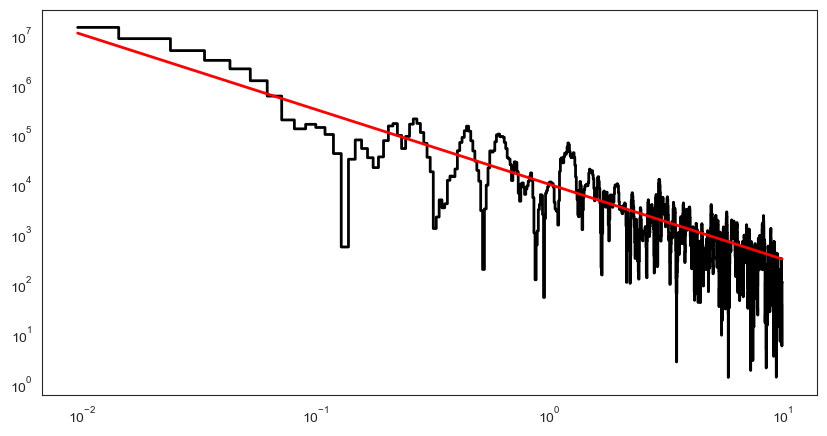

In [5]:
# flat prior for the power law index
p_alpha = lambda alpha: ((-1. <= alpha) & (alpha <= 5.))

# flat prior for the power law amplitude
p_amplitude = lambda amplitude: ((1 <= amplitude) & (amplitude <= 1e8))

# normal prior for the white noise parameter
p_whitenoise = lambda white_noise: scipy.stats.norm(2.0, 0.1).pdf(white_noise)

priors = {}
priors["alpha_0"] = p_alpha
priors["amplitude_0"] = p_amplitude
priors["amplitude_1"] = p_whitenoise

lpost = PSDPosterior(ps.freq, ps.power, plc, m=ps.m)
lpost.logprior = set_logprior(lpost, priors)

test_pars = [1e4, 1.5, 2.0]
print("log-prior: " + str(lpost.logprior(test_pars)))
print("log-likelihood: " + str(lpost.loglikelihood(test_pars)))
print("log-posterior: " + str(lpost(test_pars)))

_fitter_to_model_params(plc, test_pars)

fig, ax = plt.subplots(1, 1, figsize=(10,5))

ax.loglog(ps.freq, ps.power, lw=2, color="black", ds="steps-mid")
ax.plot(ps.freq, plc(ps.freq) , lw=2, color="red")

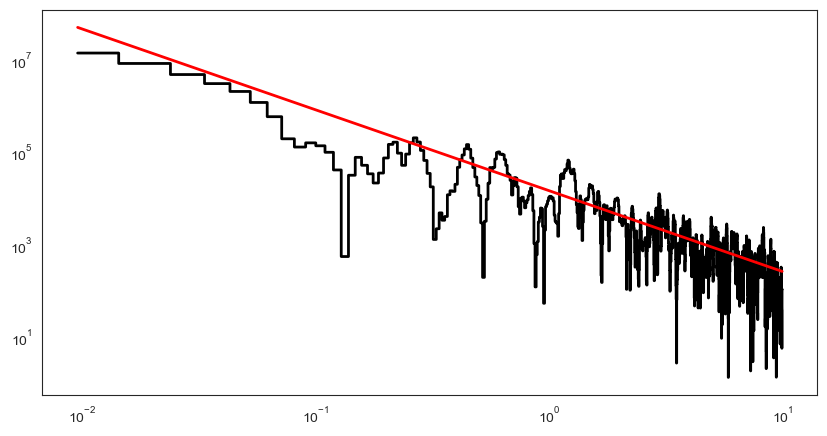

In [6]:
parest = PSDParEst(ps, fitmethod='l-bfgs-b', max_post=True)
res = parest.fit(lpost, test_pars)

fig, ax = plt.subplots(1, 1, figsize=(10,5))

ax.loglog(ps.freq, ps.power, lw=2, color="black", ds="steps-mid")
ax.plot(ps.freq, res.mfit, lw=2, color="red")

In [7]:
sample = parest.sample(lpost, res.p_opt, cov=res.cov, nwalkers=100,
             niter=1000, burnin=3000, namestr="")

Chains too short to compute autocorrelation lengths.
INFO[2024-06-04 08:15:03,769]: Chains too short to compute autocorrelation lengths.
-- The acceptance fraction is: 0.644680.5
INFO[2024-06-04 08:15:03,818]: -- The acceptance fraction is: 0.644680.5
R_hat for the parameters is: [6.97207863e+05 1.32284123e-03 9.79939596e-03]
INFO[2024-06-04 08:15:03,819]: R_hat for the parameters is: [6.97207863e+05 1.32284123e-03 9.79939596e-03]
-- Posterior Summary of Parameters: 

INFO[2024-06-04 08:15:03,822]: -- Posterior Summary of Parameters: 

parameter 	 mean 		 sd 		 5% 		 95% 

INFO[2024-06-04 08:15:03,825]: parameter 	 mean 		 sd 		 5% 		 95% 

---------------------------------------------

INFO[2024-06-04 08:15:03,828]: ---------------------------------------------

theta[0] 	 14767.467626053209	839.1526919655364	13461.769399466695	16202.290875799128

INFO[2024-06-04 08:15:03,830]: theta[0] 	 14767.467626053209	839.1526919655364	13461.769399466695	16202.290875799128

theta[1] 	 1.74974803

In [8]:
post_samples = sample.samples

<IPython.core.display.Javascript object>


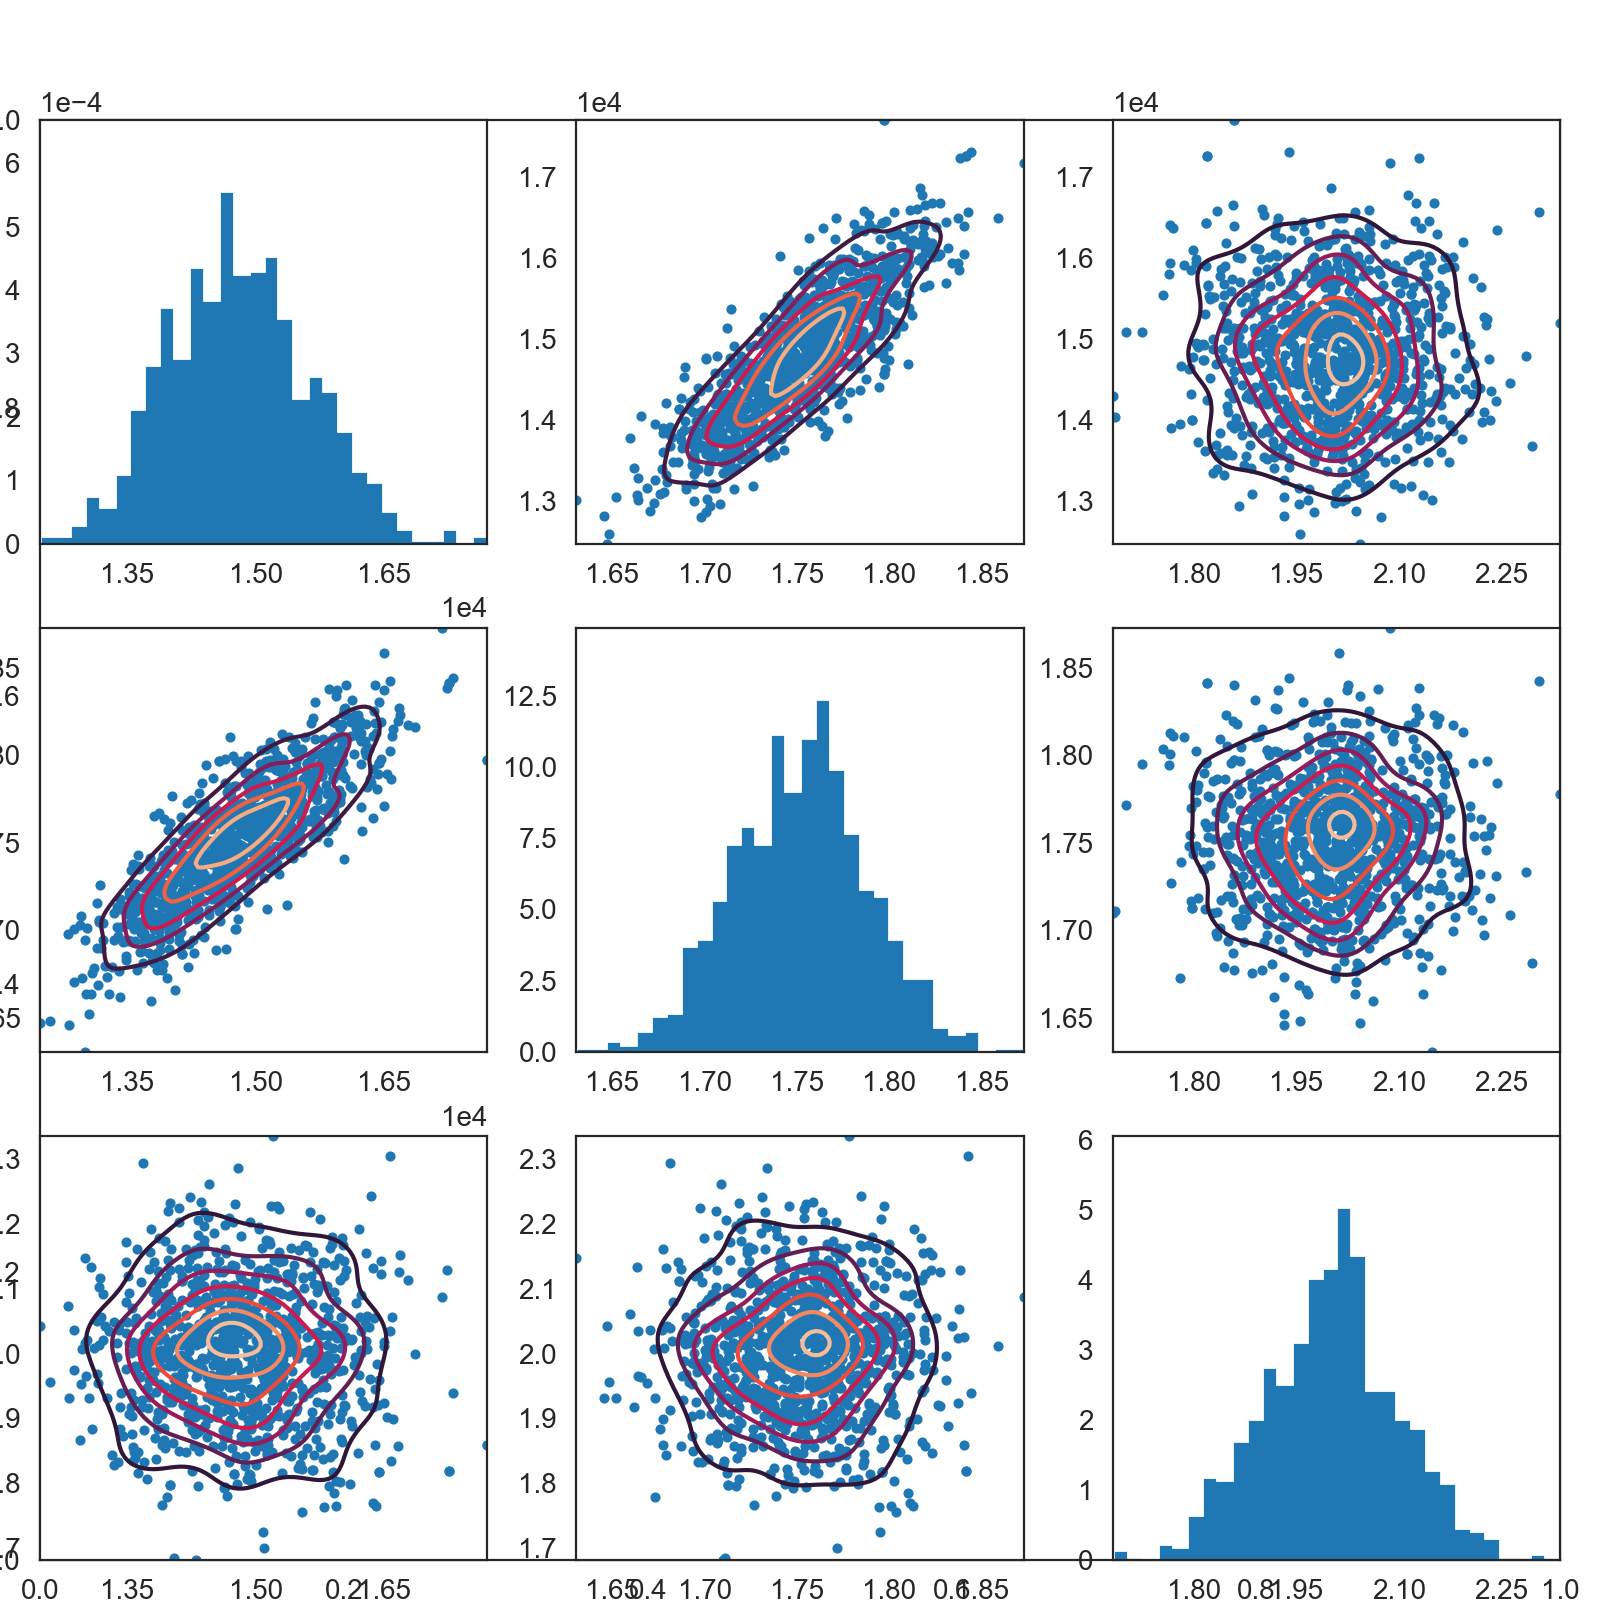

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
fig = sample.plot_results(nsamples=1000,save_plot=True, fig=fig,
                    filename="modeling_tutorial_mcmc_corner.pdf")


Let's save the sample to file:

In [10]:
np.savetxt(datadir + "grb230307a_integral_pl_sample.txt", sample.samples)

Here's how to load the samples:

In [8]:
post_samples = np.loadtxt(datadir + "grb230307a_integral_pl_sample.txt")

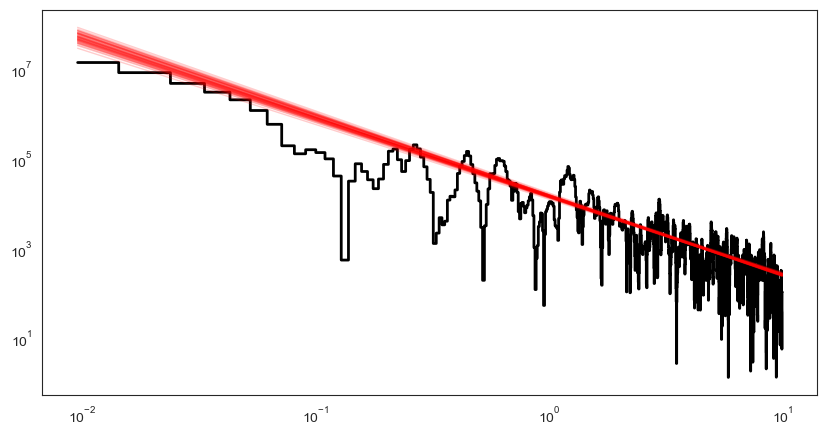

In [9]:
idx = np.random.choice(np.arange(post_samples.shape[0]), size=50, replace=False)


fig, ax = plt.subplots(1, 1, figsize=(10,5))

ax.loglog(ps.freq, ps.power, lw=2, color="black", ds="steps-mid")


for i in idx:
    _fitter_to_model_params(plc, post_samples[i])
    ax.plot(ps.freq, plc(ps.freq) , lw=1, color="red", alpha=0.2)

### Broken Powerlaw Model

Let's compare this to a broken power law model, I think the power law is overestimating the lowest frequencies;

In [10]:
# broken power law model
bpl = models.BrokenPowerLaw1D()

# add constant
bplc = bpl + c

# flat prior for the power law indices
p_alpha1 = lambda alpha: ((-1. <= alpha) & (alpha <= 5.))
p_alpha2 = lambda alpha: ((-1. <= alpha) & (alpha <= 5.))

# flat prior for the break frequency
p_x_break = lambda xbreak: ((0.01 <= xbreak) & (10.0 >= xbreak))

# flat prior for the power law amplitude
p_amplitude = lambda amplitude: ((1 <= amplitude) & (amplitude <= 1e8))

# normal prior for the white noise parameter
p_whitenoise = lambda white_noise: scipy.stats.norm(2.0, 0.1).pdf(white_noise)


priors_bpl = {}
priors_bpl["alpha_1_0"] = p_alpha
priors_bpl["alpha_2_0"] = p_alpha

priors_bpl["amplitude_0"] = p_amplitude
priors_bpl["amplitude_1"] = p_whitenoise
priors_bpl["x_break_0"] = p_x_break

Likelihood ratio: 0.044015475221385714


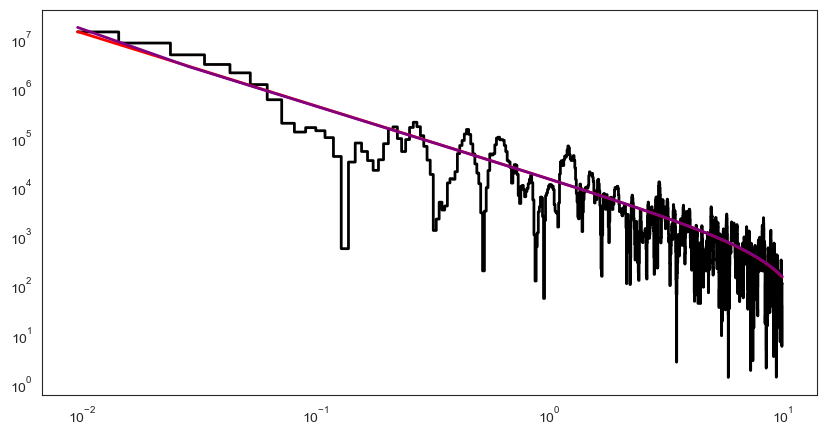

In [11]:
lpost_bplc = PSDPosterior(ps.freq, ps.power, bplc, priors=priors_bpl, m=ps.m)

parest = PSDParEst(ps, fitmethod='powell', max_post=False)
test_pars_bplc = [4e6, 0.05, 0.5, 1.7, 2.0]

lrt, plc_opt, bplc_opt = parest.compute_lrt(lpost, test_pars, lpost_bplc, test_pars_bplc)

print(f"Likelihood ratio: {lrt}")
_fitter_to_model_params(plc, plc_opt.p_opt)
_fitter_to_model_params(bplc, bplc_opt.p_opt)

fig, ax = plt.subplots(1, 1, figsize=(10,5))

ax.loglog(ps.freq, ps.power, lw=2, color="black", ds="steps-mid")
ax.plot(ps.freq, plc(ps.freq) , lw=2, color="red")
ax.plot(ps.freq, bplc(ps.freq) , lw=2, color="purple")

In [14]:
nsim = 1000
idx = np.random.choice(np.arange(post_samples.shape[0]), size=nsim, replace=False)
s_all = post_samples[idx,:]

In [33]:
lrt_sim = parest.simulate_lrts(s_all, lpost, test_pars,
                     lpost_bplc, test_pars_bplc)

In [34]:
np.savetxt(datadir + "grb230307a_integral_pl_bpl_lrt.txt", lrt_sim)

<IPython.core.display.Javascript object>


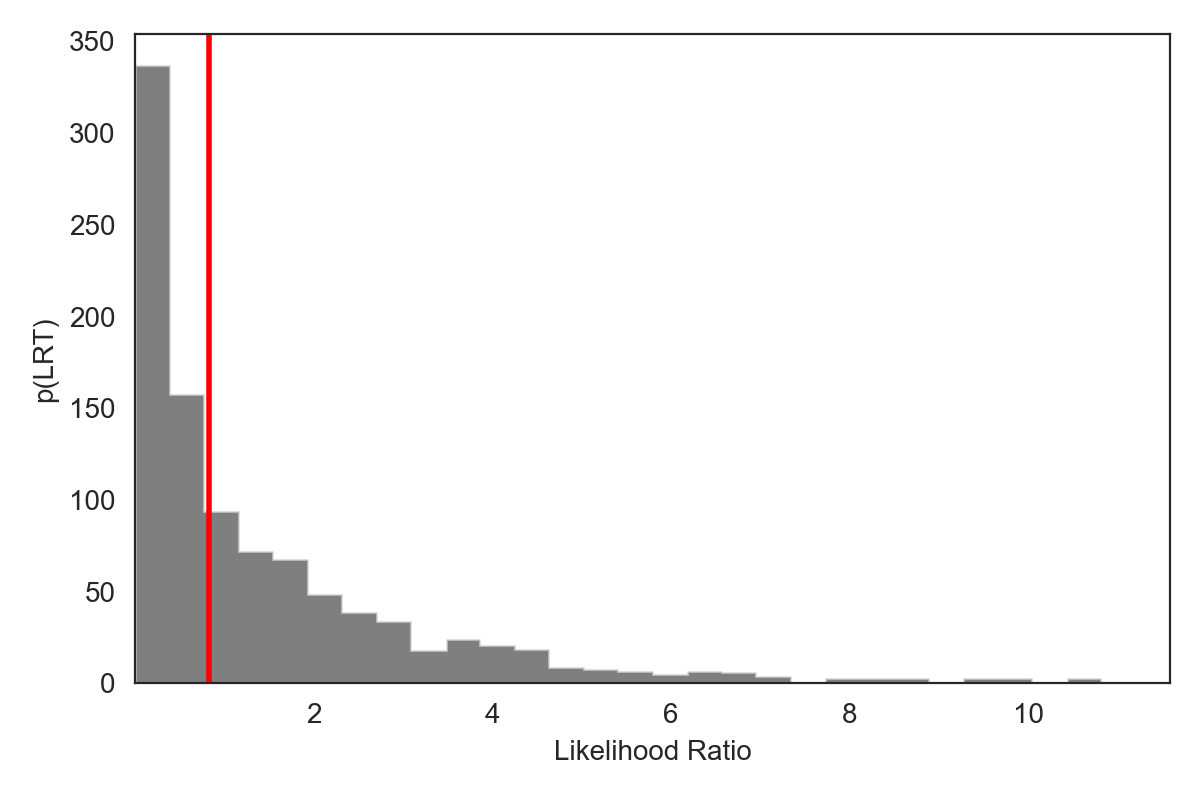

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.hist(lrt_sim, bins=30, histtype="stepfilled", alpha=0.5, color="black")

ax.axvline(lrt, lw=2, color="red")
ax.set_xlim(np.min(lrt_sim), np.max(lrt_sim))
ax.set_xlabel("Likelihood Ratio")
ax.set_ylabel("p(LRT)")
fig.tight_layout()
fig.savefig(figdir + "grb230307a_integral_pl_bpl_lrt.pdf", format="pdf")

In [36]:
np.sum(lrt_sim > lrt)/len(lrt_sim)

0.498

Meh, that's not really evidence for the presence of bent power law. Ok, let's simulate some power laws:

### Computing the highest outlier of the spectrum 

Let's compute the highest outlier and calibrate that:

In [13]:
t_sim = parest.simulate_highest_outlier(s_all, lpost, test_pars)

NameError: name 's_all' is not defined

In [79]:
np.savetxt(datadir + "grb230307a_integral_pl_tsim_lrt.txt", t_sim)

<IPython.core.display.Javascript object>


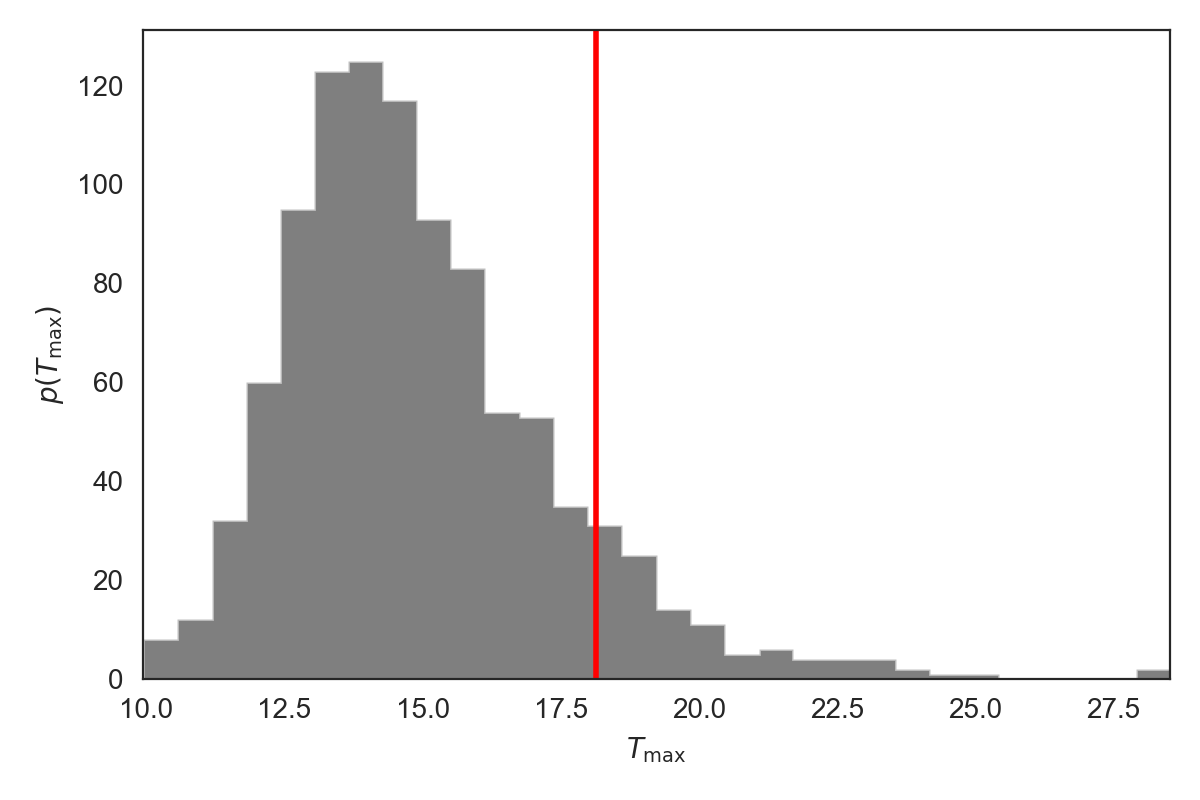

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.hist(t_sim, bins=30, histtype="stepfilled", alpha=0.5, color="black")

ax.axvline(res.maxpow, lw=2, color="red")
ax.set_xlim(np.min(t_sim), np.max(t_sim))
ax.set_xlabel(r"$T_{\mathrm{max}}$")
ax.set_ylabel(r"$p(T_{\mathrm{max}})$")
fig.tight_layout()
fig.savefig(figdir + "grb230307a_integral_pl_maxpost.pdf", format="pdf")

In [43]:
np.sum(t_sim > res.maxpow)/len(t_sim)

0.103

Okay, that's not super significant. What about a Lorentzian model comparison?

In [15]:
# broken power law model
qpoplc = models.PowerLaw1D() + models.Lorentz1D()

# fix x_0 of power law component
qpoplc.x_0_0.fixed = True

# flat prior for the power law indices
p_alpha0 = lambda alpha: ((-1. <= alpha) & (alpha <= 5.))

# flat prior for the power law amplitude
p_amplitude = lambda amplitude: ((1 <= amplitude) & (amplitude <= 1e8))

p_x0 = lambda x0: ((0.1 <= x0) & (x0 <= 2.5))
p_fwhm = lambda fwhm: ((0.001 <= fwhm) & (fwhm <= 1.0))

# normal prior for the white noise parameter
p_whitenoise = lambda white_noise: scipy.stats.norm(2.0, 0.1).pdf(white_noise)

priors_qpopl = {"amplitude_0": p_amplitude,
                "alpha_0": p_alpha0,
                "amplitude_1": p_amplitude,
                "x_0_1": p_x0,
                "fwhm_1": p_fwhm,
                }

[1.20205314e+04 1.65045702e+00 4.99428802e+04 1.21638493e+00
 8.29029324e-02]
Likelihood ratio: 24.468870376185805


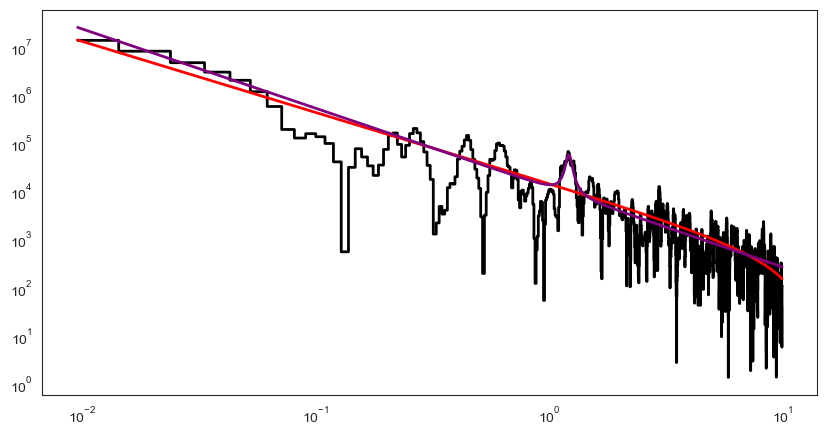

In [16]:
lpost_qpoplc = PSDPosterior(ps.freq, ps.power, qpoplc, priors=priors_qpopl, m=ps.m)

parest = PSDParEst(ps, fitmethod='bfgs', max_post=False)
test_pars_qpoplc = [1e4, 1.5, 5e4, 1.2, 0.1]

lrt, plc_opt, qpoplc_opt = parest.compute_lrt(lpost, test_pars, lpost_qpoplc, test_pars_qpoplc)
print(qpoplc_opt.p_opt)
print(f"Likelihood ratio: {lrt}")
_fitter_to_model_params(plc, plc_opt.p_opt)
_fitter_to_model_params(qpoplc, qpoplc_opt.p_opt)

fig, ax = plt.subplots(1, 1, figsize=(10,5))

ax.loglog(ps.freq, ps.power, lw=2, color="black", ds="steps-mid")
ax.plot(ps.freq, plc(ps.freq) , lw=2, color="red")
ax.plot(ps.freq, qpoplc(ps.freq) , lw=2, color="purple")

Let's run a model comparison:

In [60]:
lrt_sim_qpo = parest.simulate_lrts(s_all, lpost, test_pars,
                     lpost_qpoplc, test_pars_qpoplc)

In [61]:
np.savetxt(datadir + "grb230307a_integral_qpo_tsim_lrt.txt", lrt_sim_qpo)

In [19]:
lrt_sim_qpo = np.loadtxt(datadir + "grb230307a_integral_qpo_tsim_lrt.txt")

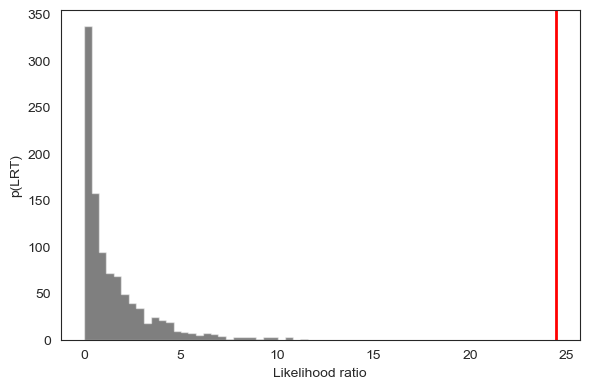

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.hist(lrt_sim_qpo, bins=30, histtype="stepfilled", alpha=0.5, color="black")

ax.axvline(lrt, lw=2, color="red")
#ax.set_xlim(np.min(lrt_sim_qpo), np.max(lrt_sim_qpo))
ax.set_xlabel("Likelihood ratio")
ax.set_ylabel("p(LRT)")
fig.tight_layout()
fig.savefig(figdir + "grb230307a_integral_pl_qpopl_lrt.pdf", format="pdf")

Okay, so that's *very* significant. But is it *meaningful*? That's the question.

### MCMC on model with QPO

So that I can have proper estimates of QPO parameters:

In [99]:
sample = parest.sample(lpost_qpoplc, qpoplc_opt.p_opt, nwalkers=100,
             niter=1000, burnin=3000, namestr="")

Chains too short to compute autocorrelation lengths.
INFO[2024-03-22 15:57:05,293]: Chains too short to compute autocorrelation lengths.
-- The acceptance fraction is: 0.447910.5
INFO[2024-03-22 15:57:05,366]: -- The acceptance fraction is: 0.447910.5
R_hat for the parameters is: [5.53797542e+05 1.32422479e-03 3.83356177e+10 2.56362619e-04
 2.46158092e-03]
INFO[2024-03-22 15:57:05,367]: R_hat for the parameters is: [5.53797542e+05 1.32422479e-03 3.83356177e+10 2.56362619e-04
 2.46158092e-03]
-- Posterior Summary of Parameters: 

INFO[2024-03-22 15:57:05,368]: -- Posterior Summary of Parameters: 

parameter 	 mean 		 sd 		 5% 		 95% 

INFO[2024-03-22 15:57:05,370]: parameter 	 mean 		 sd 		 5% 		 95% 

---------------------------------------------

INFO[2024-03-22 15:57:05,371]: ---------------------------------------------

theta[0] 	 12028.24650166075	747.8881862278879	10845.645923492399	13281.922546205824

INFO[2024-03-22 15:57:05,371]: theta[0] 	 12028.24650166075	747.8881862278879	

In [100]:
np.savetxt(datadir + "grb230307a_integral_qpopl_sample.txt", sample.samples)

In [ ]:
post_samples = sample.samples

<IPython.core.display.Javascript object>


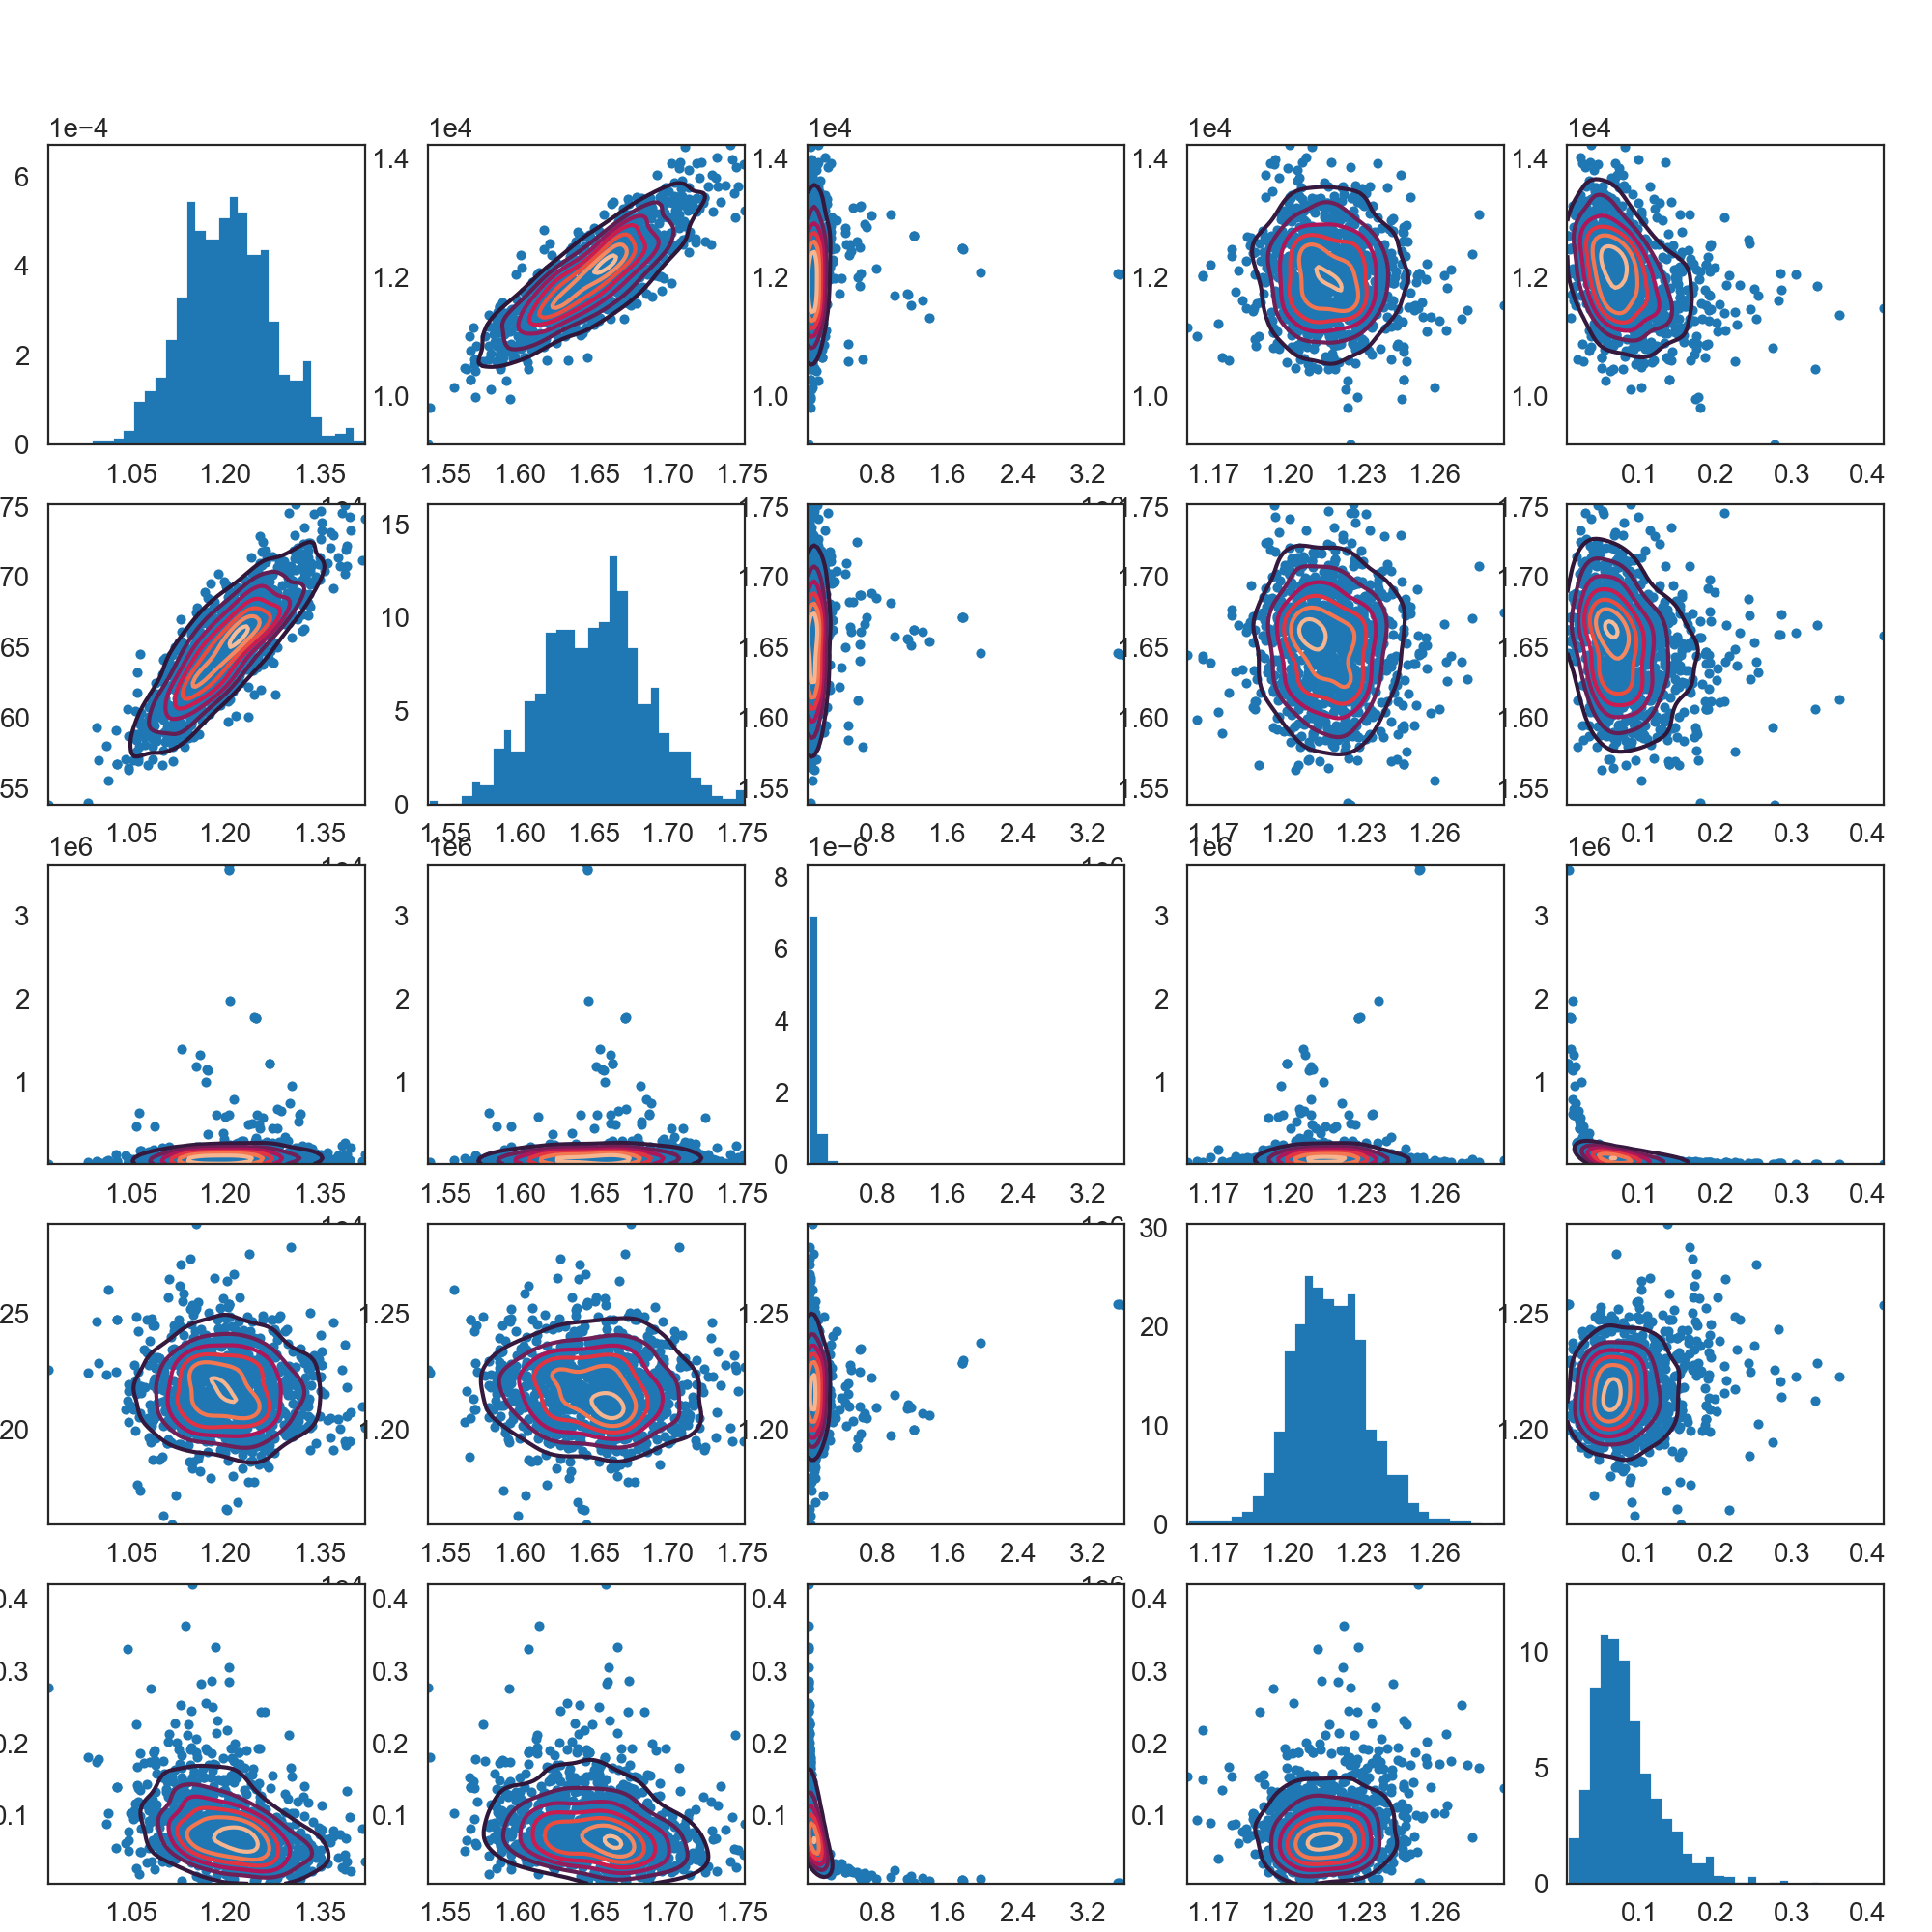

<IPython.core.display.Javascript object>


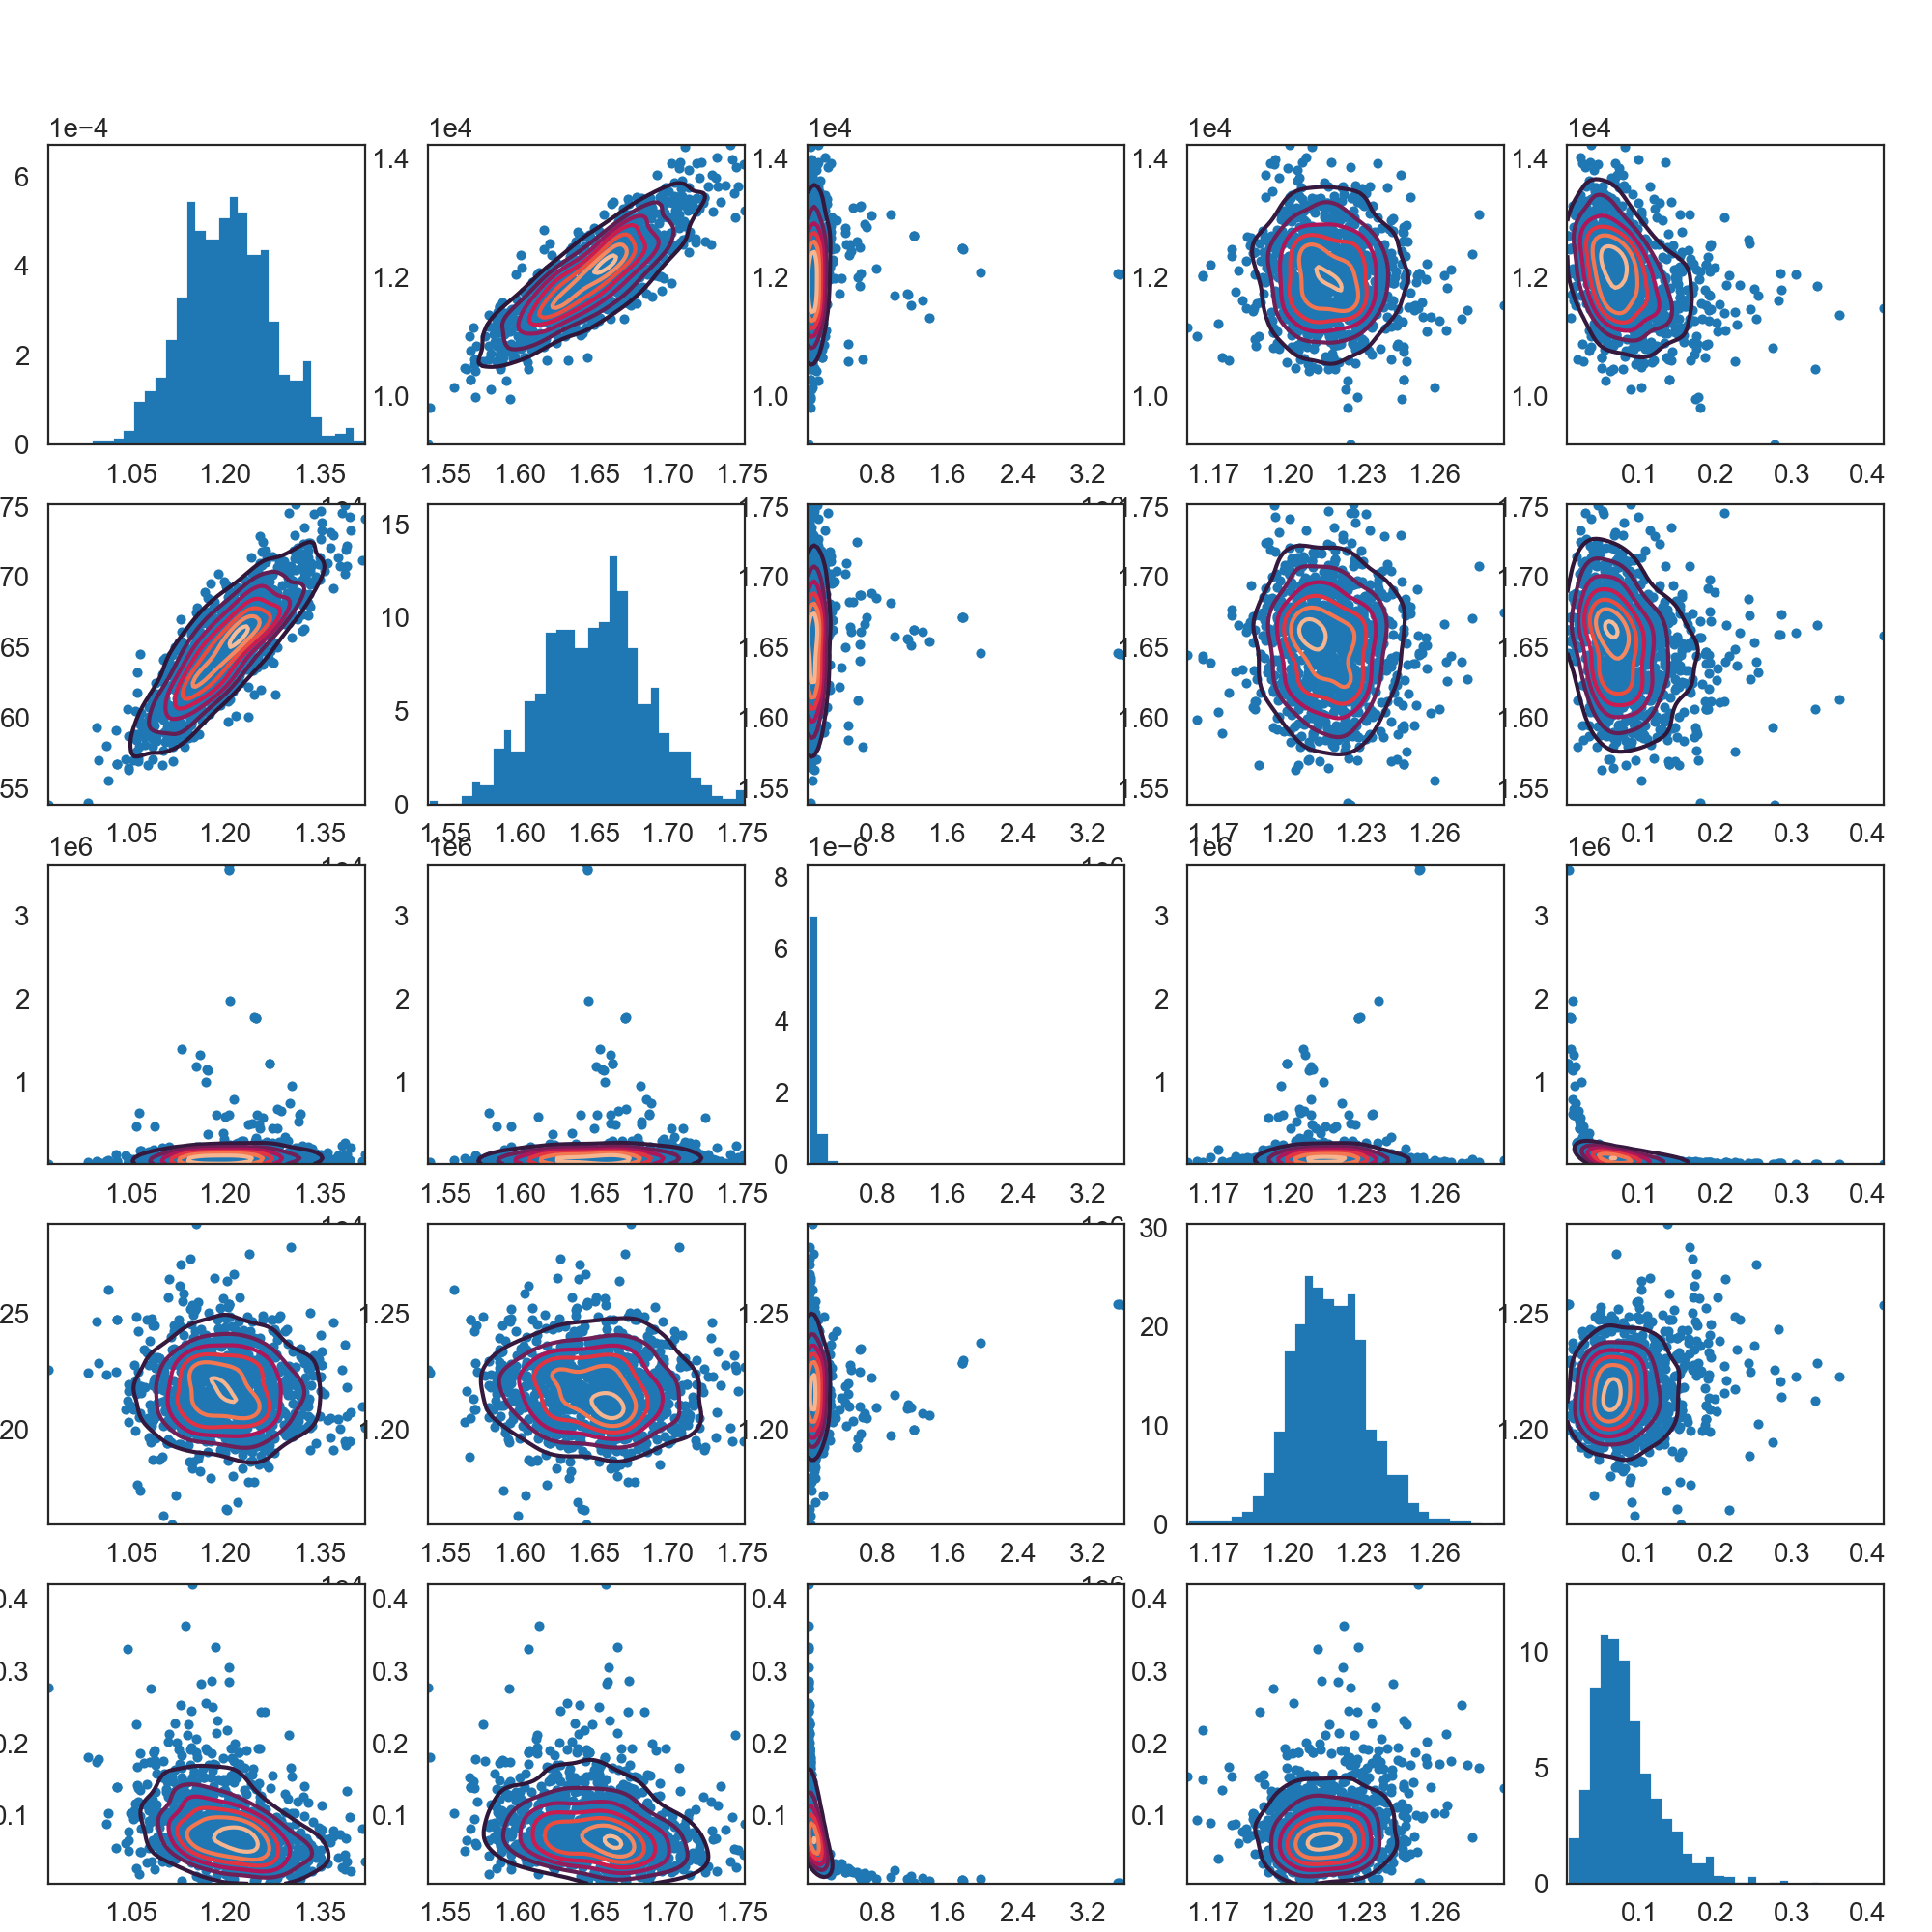

In [104]:
fig = plt.figure(figsize=(10,10))
fig = sample.plot_results(fig=fig)

Loading the samples from file:

In [38]:
post_samples_qpo = np.loadtxt(datadir + "grb230307a_integral_qpopl_sample.txt")

<IPython.core.display.Javascript object>


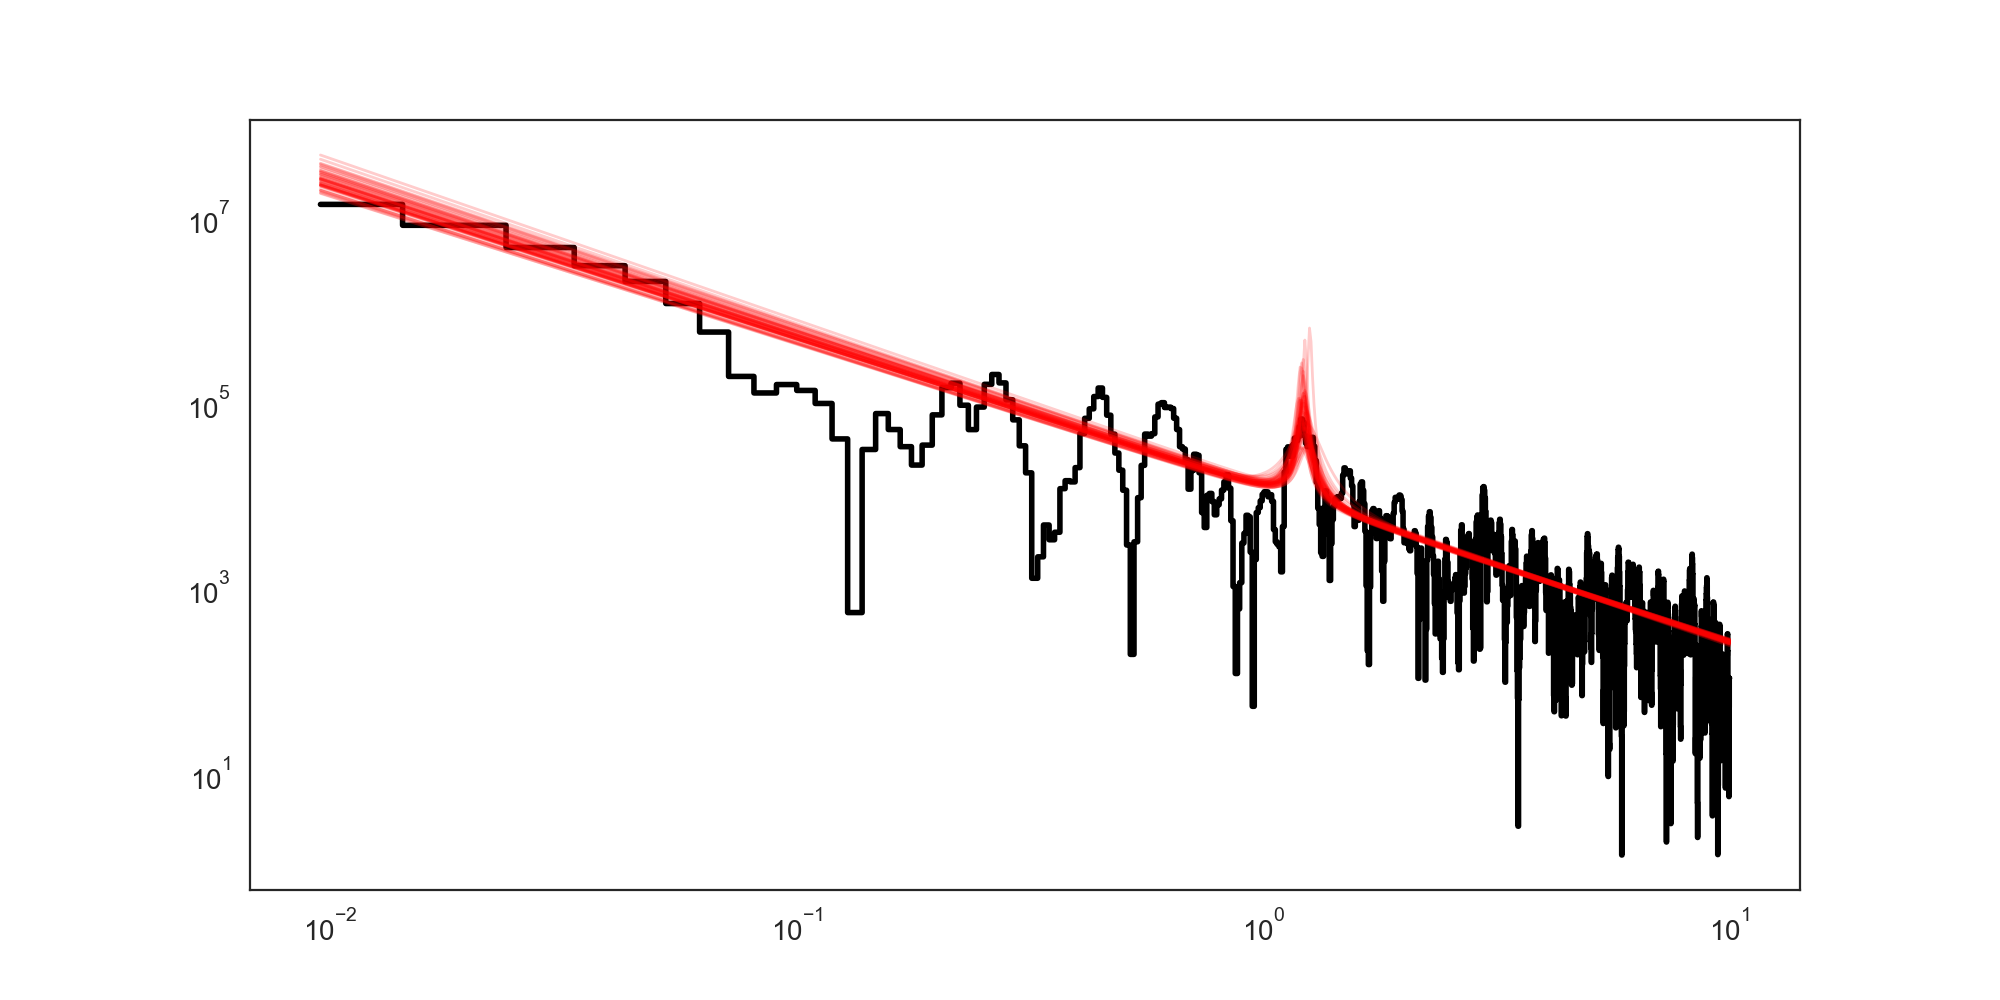

In [39]:
idx = np.random.choice(np.arange(post_samples_qpo.shape[0]), size=50, replace=False)


fig, ax = plt.subplots(1, 1, figsize=(10,5))

ax.loglog(ps.freq, ps.power, lw=2, color="black", ds="steps-mid")


for i in idx:
    _fitter_to_model_params(qpoplc, post_samples_qpo[i])
    ax.plot(ps.freq, qpoplc(ps.freq) , lw=1, color="red", alpha=0.2)

## Model Comparison: 1 vs 2 Lorentzians

In [31]:
# broken power law model
two_qpoplc = models.PowerLaw1D() + models.Lorentz1D() + models.Lorentz1D()

# fix x_0 of power law component
two_qpoplc.x_0_0.fixed = True

# flat prior for the power law indices
p_alpha0 = lambda alpha: ((-1. <= alpha) & (alpha <= 5.))

# flat prior for the power law amplitude
p_amplitude = lambda amplitude: ((1 <= amplitude) & (amplitude <= 1e8))


In [53]:
p_x0_1 = lambda x0: ((0.1 <= x0) & (x0 <= 2.0))
p_x0_2 = lambda x0: ((2.0 <= x0) & (x0 <= 5.0))

p_fwhm_1 = lambda fwhm: ((0.001 <= fwhm) & (fwhm <= 1.0))
p_fwhm_2 = lambda fwhm: ((0.001 <= fwhm) & (fwhm <= 2.5))


priors_two_qpopl = {"amplitude_0": p_amplitude,
                "alpha_0": p_alpha0,
                "amplitude_1": p_amplitude,
                "x_0_1": p_x0_1,
                "fwhm_1": p_fwhm_1,
                'amplitude_2':p_amplitude,
                'x_0_2':p_x0_2,
                'fwhm_2':p_fwhm_2
                }

[1.10581962e+04 1.63182089e+00 5.00483273e+04 1.21711334e+00
 8.74760185e-02 9.93538175e+03 2.98067015e+00 7.39383743e-02]
Likelihood ratio: 38.8632980127295


<IPython.core.display.Javascript object>


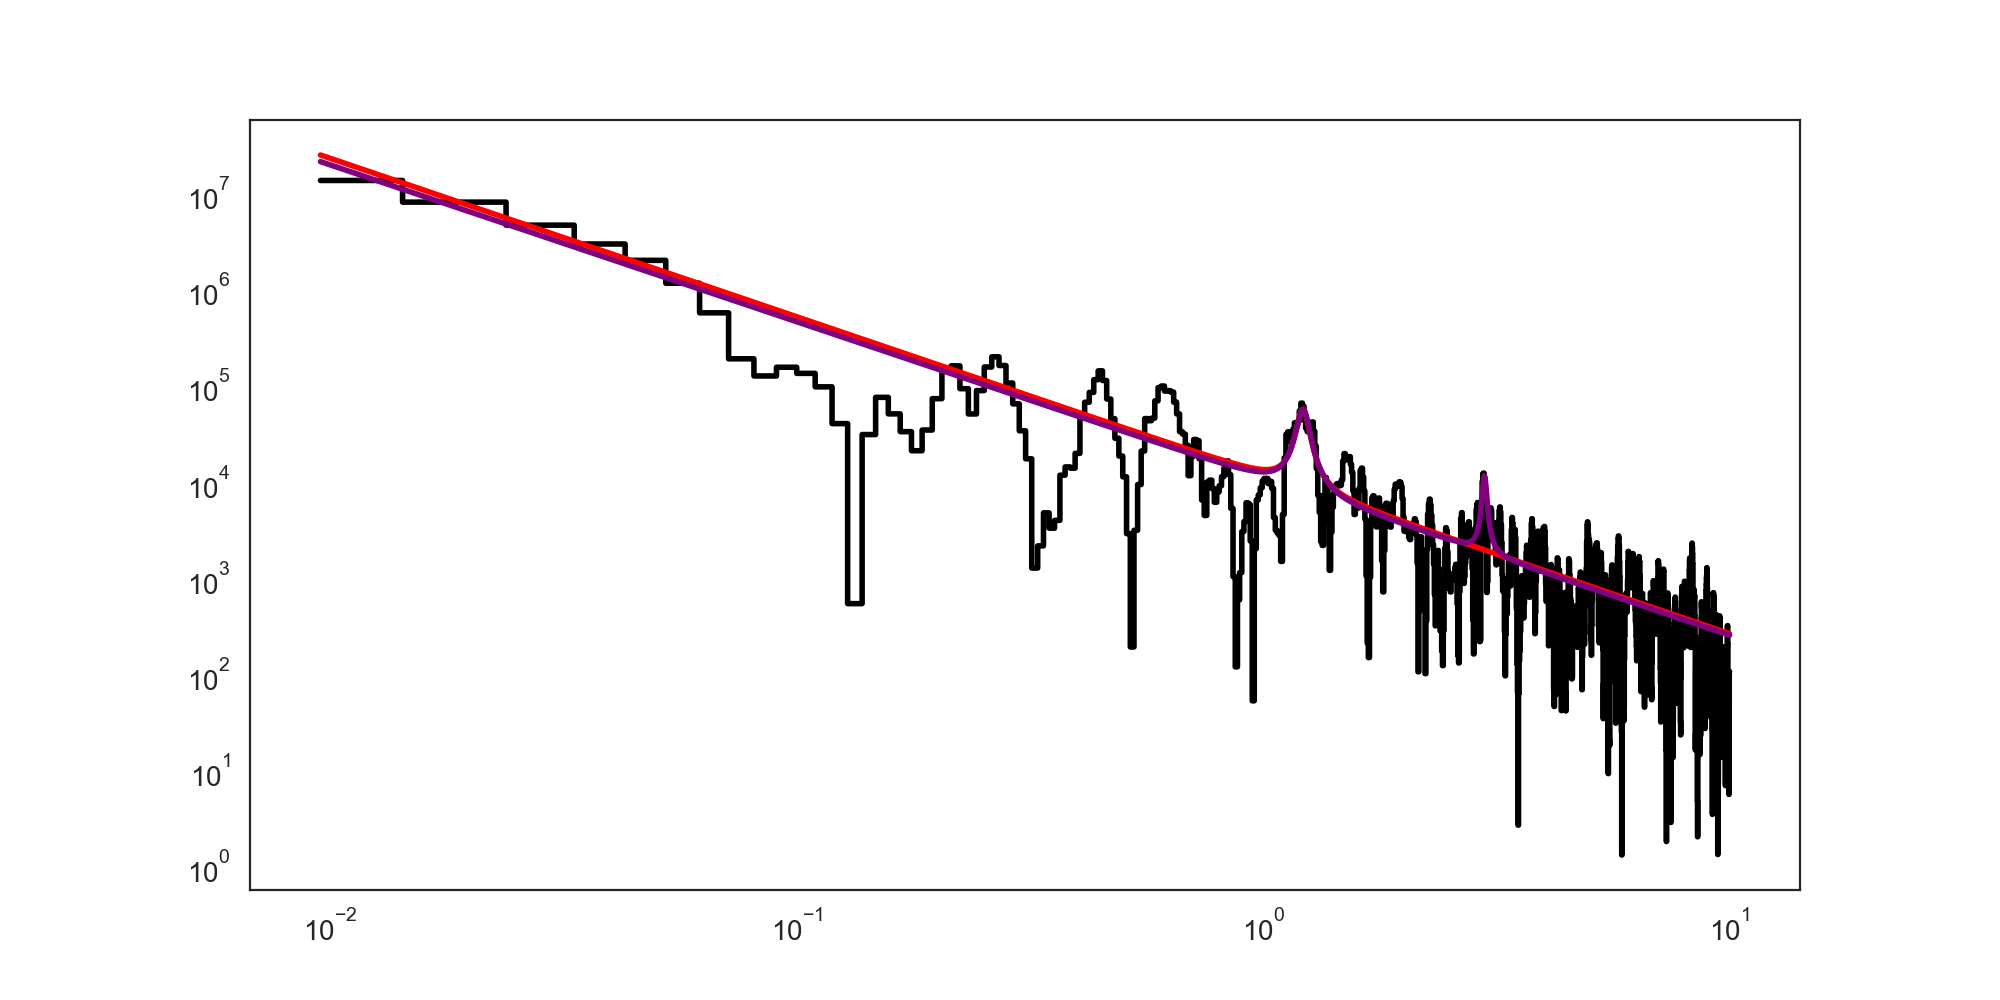

In [60]:
lpost_twoqpoplc = PSDPosterior(ps.freq, ps.power, two_qpoplc, priors=priors_two_qpopl, m=ps.m)

parest = PSDParEst(ps, fitmethod='bfgs', max_post=False)
test_pars_two_qpoplc = [1e4, 1.5, 5e4, 1.2, 0.05, 1e4, 2.9, 0.01]

lrt_twoqpo, qpoplc_opt, two_qpoplc_opt = parest.compute_lrt(lpost_qpoplc, test_pars_qpoplc, lpost_twoqpoplc, test_pars_two_qpoplc)
print(two_qpoplc_opt.p_opt)
print(f"Likelihood ratio: {lrt}")
_fitter_to_model_params(qpoplc, qpoplc_opt.p_opt)
_fitter_to_model_params(two_qpoplc, two_qpoplc_opt.p_opt)

fig, ax = plt.subplots(1, 1, figsize=(10,5))

ax.loglog(ps.freq, ps.power, lw=2, color="black", ds="steps-mid")
ax.plot(ps.freq, qpoplc(ps.freq) , lw=2, color="red")
ax.plot(ps.freq, two_qpoplc(ps.freq) , lw=2, color="purple")

Let's calibrate the LRT:

In [57]:
nsim = 1000
idx = np.random.choice(np.arange(post_samples_qpo.shape[0]), size=nsim, replace=False)
s_all_qpo = post_samples_qpo[idx,:]

lrt_sim_twoqpo = parest.simulate_lrts(s_all_qpo, lpost_qpoplc, test_pars_qpoplc,
                     lpost_twoqpoplc, test_pars_two_qpoplc)

KeyboardInterrupt: 

In [44]:
np.savetxt(datadir + "grb230307a_integral_twoqpo_tsim_lrt.txt", lrt_sim_twoqpo)

<IPython.core.display.Javascript object>


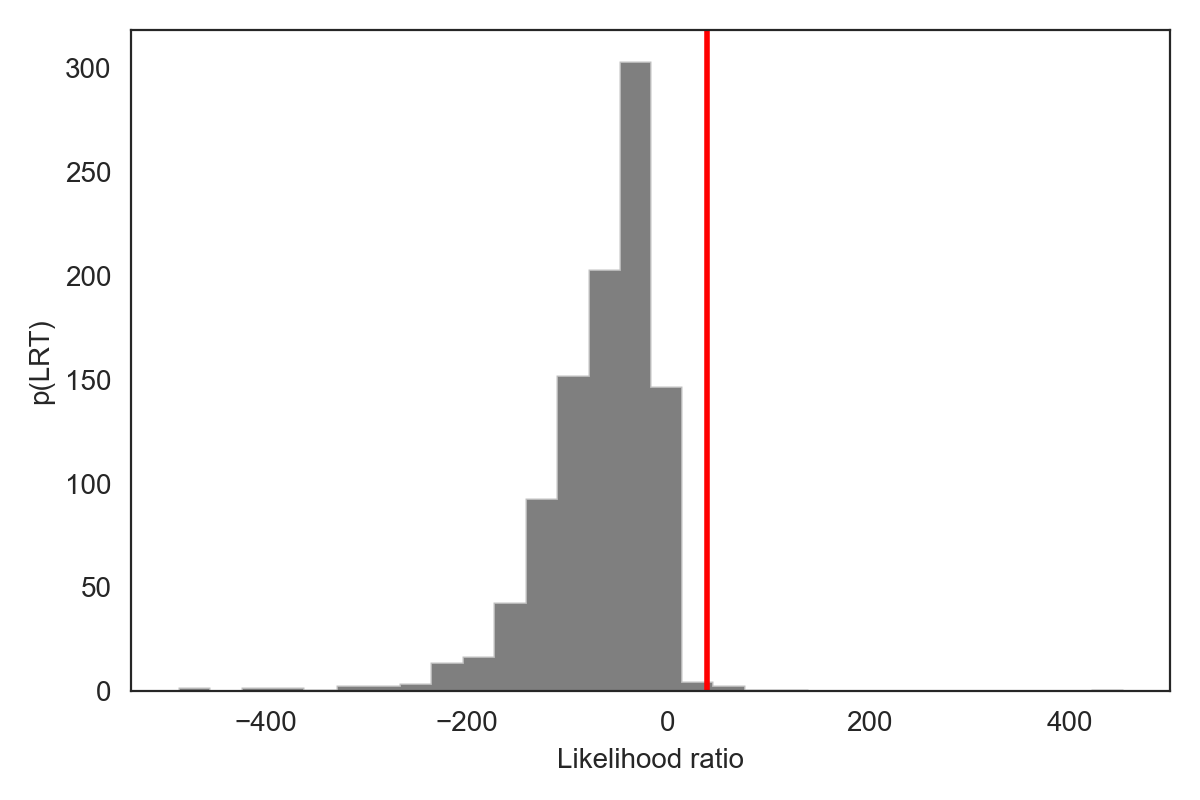

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.hist(lrt_sim_twoqpo, bins=30, histtype="stepfilled", alpha=0.5, color="black")

ax.axvline(lrt, lw=2, color="red")
#ax.set_xlim(np.min(lrt_sim_qpo), np.max(lrt_sim_qpo))
ax.set_xlabel("Likelihood ratio")
ax.set_ylabel("p(LRT)")
fig.tight_layout()
fig.savefig(figdir + "grb230307a_integral_twoqpopl_lrt.pdf", format="pdf")

In [47]:
np.sum((lrt_sim_twoqpo > lrt))/nsim

0.006

In [64]:
sample = parest.sample(lpost_twoqpoplc, two_qpoplc_opt.p_opt, cov=two_qpoplc_opt.cov/10, nwalkers=100,
             niter=1000, burnin=2000, namestr="")

Chains too short to compute autocorrelation lengths.
INFO[2024-03-27 12:52:41,032]: Chains too short to compute autocorrelation lengths.
-- The acceptance fraction is: 0.332540.5
INFO[2024-03-27 12:52:41,108]: -- The acceptance fraction is: 0.332540.5
R_hat for the parameters is: [4.58803093e+05 1.21319868e-03 8.52862762e+09 2.91808026e-04
 2.54468067e-03 7.37572936e+08 6.77000360e-04 5.55543191e-03]
INFO[2024-03-27 12:52:41,111]: R_hat for the parameters is: [4.58803093e+05 1.21319868e-03 8.52862762e+09 2.91808026e-04
 2.54468067e-03 7.37572936e+08 6.77000360e-04 5.55543191e-03]
-- Posterior Summary of Parameters: 

INFO[2024-03-27 12:52:41,112]: -- Posterior Summary of Parameters: 

parameter 	 mean 		 sd 		 5% 		 95% 

INFO[2024-03-27 12:52:41,114]: parameter 	 mean 		 sd 		 5% 		 95% 

---------------------------------------------

INFO[2024-03-27 12:52:41,116]: ---------------------------------------------

theta[0] 	 11038.76886700618	680.7415534204717	9970.844073164504	12194.318

In [65]:
np.savetxt(datadir + "grb230307a_integral_twoqpopl_sample.txt", sample.samples)

## Simulating light curves with power-law spectra:

In [31]:
from stingray.simulator.simulator import Simulator

In [32]:
1.217/0.094

12.946808510638299

Time resolution of the simulated light curves: 0.04999971389770508
Number of time bins in the simulated light curves: 2101
Mean number of counts per bin in the simulated light curves: 11781.493574488339


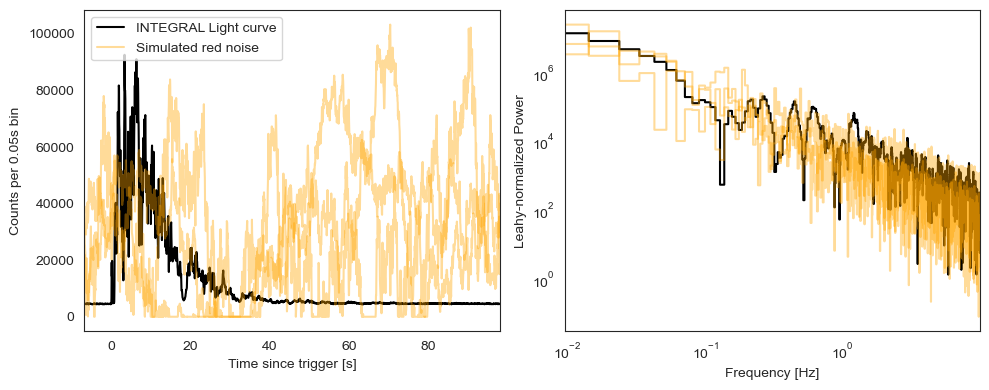

In [42]:
dt = lc.dt
print("Time resolution of the simulated light curves: " + str(dt))

nbins = int(lc.tseg/lc.dt)
print("Number of time bins in the simulated light curves: " + str(nbins))

mean_counts = np.mean(lc.counts)
print("Mean number of counts per bin in the simulated light curves: " + str(mean_counts))

sim = Simulator(dt=dt, N=nbins, mean=mean_counts+16000, rms=0.9, tstart = lc.time[0])

# exponential version
#sim = Simulator(dt=dt, N=nbins, mean=np.log(mean_counts), rms=0.1, tstart = lc.time[0])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.plot(lc.time, lc.counts, color="black", label="INTEGRAL Light curve")
ax2.loglog(ps.freq, ps.power, ds="steps-mid", color="black")

np.random.seed(1200)

nsims = 1000
idx = np.random.choice(np.arange(post_samples.shape[0]), size=nsims, replace=False)

for i in idx[:3]:
    _fitter_to_model_params(plc, post_samples[i])

    pl_model = plc(ps.freq)
    lc_sim = sim.simulate(pl_model)
    
    # non-exponential version:
    lc_sim.counts[lc_sim.counts < 0] = 0.0
    counts = np.random.poisson(lc_sim.counts)
    
    # exponential version
    #counts = np.random.poisson(np.exp(lc_sim.counts))
    
    lc_sim = Lightcurve(lc_sim.time, counts, dt=lc_sim.dt, skip_checks=True)
    ps_sim = Powerspectrum(lc_sim, norm="leahy")
    
    if i == idx[0]:
        ax1.plot(lc_sim.time, lc_sim.counts, color="orange", alpha=0.4, label="Simulated red noise")
        ax2.loglog(ps_sim.freq, ps_sim.power, ds="steps-mid", color="orange", alpha=0.4)

    else:
        ax1.plot(lc_sim.time, lc_sim.counts, color="orange", alpha=0.4)
        ax2.loglog(ps_sim.freq, ps_sim.power, ds="steps-mid", color="orange", alpha=0.4)

ax1.legend()
ax1.set_xlim(lc.time[0], lc.time[-1])
ax2.set_xlim(ps.freq[0], ps.freq[-1])

ax1.set_xlabel("Time since trigger [s]")
ax1.set_ylabel("Counts per 0.05s bin")
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("Leahy-normalized Power")

fig.tight_layout()
fig.savefig(figdir + "grb230307a_rednoise_sims.pdf", format="pdf")

Let's make many of these and then calculate the wavelet transform and save all of those so I can do cool stuff with it.

## Simulating from a Mean Function + GP

Let's take a look at the mean function + GP framework

In [ ]:
import sys
sys.path.append("../code/") 
from integral_fap import simulate_grb

In [97]:
with open(datadir+"intregal_drw_res.pkl", "rb") as f:
    gpresult_rn = pickle.load(f)

In [29]:
 0.11989759723270965-0.024539791730273777

0.09535780550243587

In [30]:
0.25322944839403194- 0.11989759723270965

0.1333318511613223

<IPython.core.display.Javascript object>


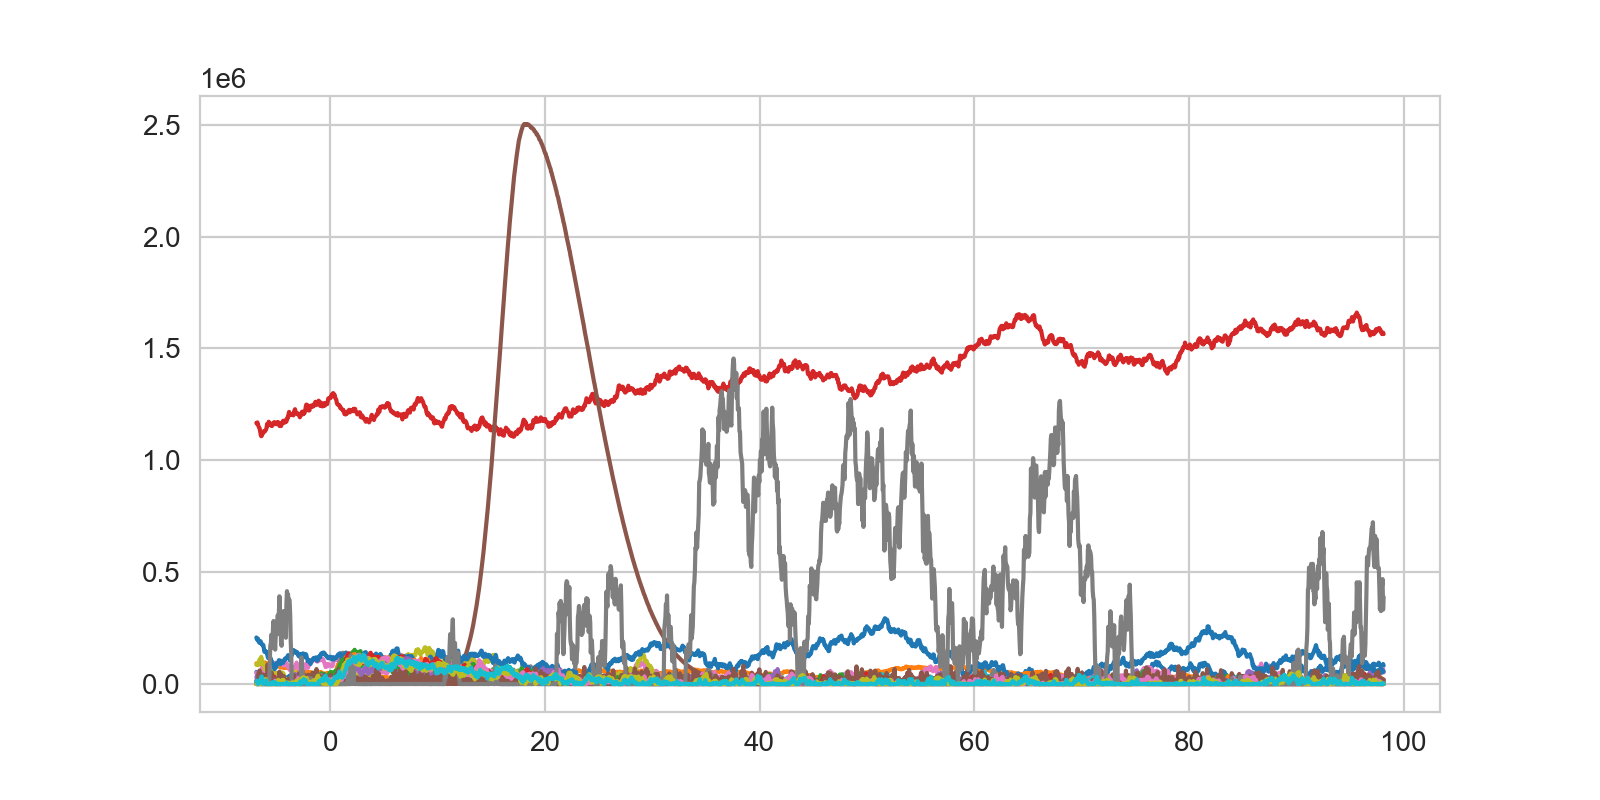

In [107]:
nsamples = gpresult_rn.samples["log_A"].shape[0]
nsim = 20

idx_all = np.random.choice(np.arange(1, nsamples, 1, dtype=int), size=nsim)

fig, ax = plt.subplots(1, 1, figsize=(8,4))

for idx in idx_all:
    pars_log = {key: gpresult_rn.samples[key][idx] for key in gpresult_rn.samples.keys()}

    lc_sim = simulate_grb(pars_log, lc.time)
    ax.plot(lc_sim.time, lc_sim.counts)

<IPython.core.display.Javascript object>


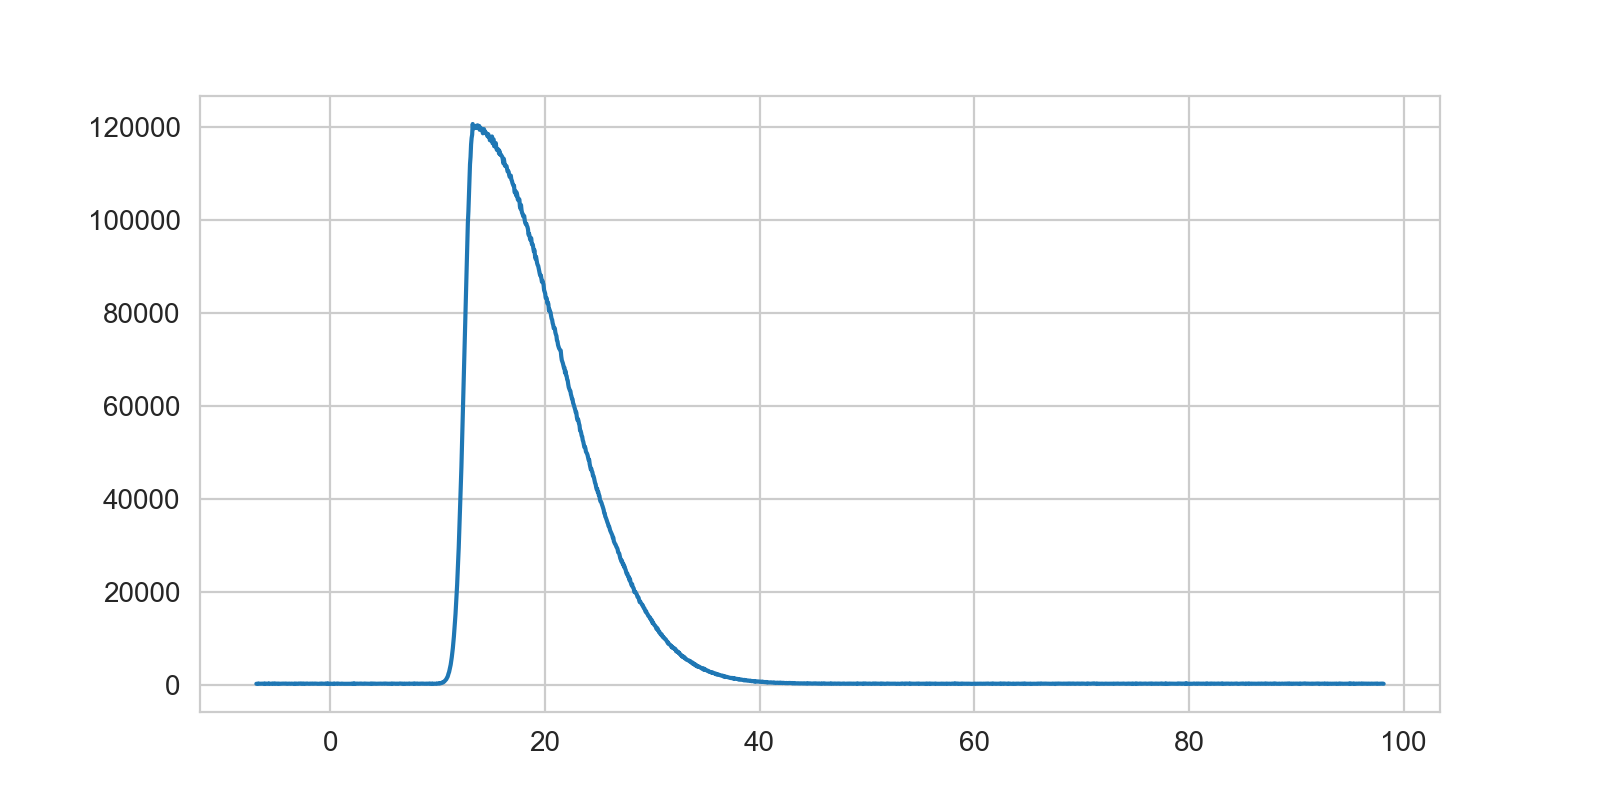